In [1]:
import sys
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.patches as patches

In [2]:

fontsize = 18
def hist1d(x1,x2,xlabel:str = '',density = True, bins = 'auto'):
    plt.figure(figsize=(8, 6))
    #bins = np.linspace(0, max(np.max(x1),np.max(x2)), 50) if predefined_bins else 'auto'
    n1, bins, patches = plt.hist(x1, bins=bins, density=density, histtype='step', label='Independent Geant4', color='orange', linewidth=2.5)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    errors1 = np.sqrt(n1)
    if not density: plt.errorbar(bin_centers, n1, yerr=errors1, color='orange',fmt='none')
    n2, _, _ = plt.hist(x2, bins=bins, density=density, histtype='step', label='FairShip', color='blue')
    errors2 = np.sqrt(n2)
    if not density: plt.errorbar(bin_centers, n2, yerr=errors2, color='blue',fmt='none')
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=fontsize)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=fontsize)  # Minor ticks (if needed)




def hist2d(x, x_fs, fontsize=12):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
    fig.tight_layout()

    # First histogram (Enriched Sample)
    h1, xedges, yedges, im1 = axes[0].hist2d(*x, bins=50, cmap='viridis', norm=LogNorm(), density=False)
    axes[0].set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
    axes[0].set_ylabel('$P_t$ [GeV]', fontsize=fontsize)
    axes[0].set_title('Enriched Sample', fontsize=fontsize)
    cbar1 = fig.colorbar(im1, ax=axes[0], label='Density')

    # Second histogram (Full Sample)
    h2, _, _, im2 = axes[1].hist2d(*x_fs, bins=[xedges, yedges], cmap='viridis', norm=LogNorm(), density=False)
    axes[1].set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
    axes[1].set_title('Full Sample', fontsize=fontsize)
    cbar2 = fig.colorbar(im2, ax=axes[1], label='Density')

    # Adjust tick parameters
    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=fontsize)

    plt.show()

def difference_hist1d(x1,x2,xlabel:str = '',density = True, bins = 'auto'):
    n1, bins, patches = plt.hist(x1, bins=bins, density=density, histtype='step', label='Independent Geant4', color='orange', linewidth=2.5)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    n2, _, _ = plt.hist(x2, bins=bins, density=density, histtype='step', label='FairShip', color='blue')
    diff = n1-n2
    plt.close()
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Calculate bin centers for plotting

    plt.figure(figsize=(8, 6))
    plt.bar(bin_centers, diff, width=np.diff(bins), color='blue', edgecolor='black', alpha=0.7)

    plt.xlabel(xlabel,fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=fontsize)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=fontsize)  # Minor ticks (if needed)


In [3]:
def extract_number_from_string(s):
    number_str = ''
    for char in s:
        if char.isdigit(): 
            number_str += char
    return int(number_str)

In [4]:
folder = '/home/hep/lprate/projects/MuonsAndMatter/data/outputs/'
params_name = 'supernut_v3'
sample = 'subsample_biased_v4'

file_name = f'output_{params_name}_{sample}.pkl'
with open(os.path.join(folder,file_name), 'rb') as f:
    data = pickle.load(f)
print(data.shape)

(1000000,)


In [5]:
sys.path.append('/home/hep/lprate/projects/MuonsAndMatter/python/lib/reference_designs')
import params as params_lib

if hasattr(params_lib, params_name):
    params = getattr(params_lib, params_name)
else:
    with open(f"/home/hep/lprate/projects/BlackBoxOptimization/outputs/{params_name}/phi_optm.txt", "r") as txt_file:
        params = [float(line.strip()) for line in txt_file]
params = np.array(params)

In [6]:

def get_arb8(params, z_start=0.0,z_gap = 0.1, Ym_gap=0.0):
    """
    Returns the 8 3D corners for the core block and yoke, with correct Z placement.
    z_start: the Z coordinate where this block starts (in meters)
    z_gap: gap after previous block (in meters)
    Ym_gap: extra gap in Y (if needed)
    """
    ratio_yoke_1 = params[7]
    ratio_yoke_2 = params[8]
    params = params / 100
    dZ = params[0] - z_gap/2
    dX = params[1]
    dX2 = params[2]
    dY = params[3]
    dY2 = params[4]
    gap = params[5]
    gap2 = params[6]
    dY_yoke_1 = params[9]
    dY_yoke_2 = params[10]
    X_mgap_1 = params[11]
    X_mgap_2 = params[12]

    # Z positions (bottom and top), shifted by z_start and z_gap
    z1 = z_start + z_gap/2
    z2 = z1 + 2*dZ

    # core block X and Y at z1 and z2
    x1_core = X_mgap_1
    x2_core = dX + X_mgap_1
    x1_core_top = X_mgap_2
    x2_core_top = dX2 + X_mgap_2

    y1_core = -dY
    y2_core = dY
    y1_core_top = -dY2
    y2_core_top = dY2

    # Yoke block X and Y at z1 and z2
    x1_yoke = dX + X_mgap_1 + gap
    x2_yoke = dX + X_mgap_1 + gap + dX * ratio_yoke_1
    x1_yoke_top = dX2 + X_mgap_2 + gap2
    x2_yoke_top = dX2 + X_mgap_2 + gap2 + dX2 * ratio_yoke_2

    y1_yoke = -dY - dY_yoke_1 - Ym_gap
    y2_yoke = dY + dY_yoke_1 + Ym_gap
    y1_yoke_top = -dY2 - dY_yoke_2 - Ym_gap
    y2_yoke_top = dY2 + dY_yoke_2 + Ym_gap

    # core block corners (bottom face, then top face)
    core_corners = np.array([
        [x1_core, y1_core, z1],
        [x2_core, y1_core, z1],
        [x2_core, y2_core, z1],
        [x1_core, y2_core, z1],
        [x1_core_top, y1_core_top, z2],
        [x2_core_top, y1_core_top, z2],
        [x2_core_top, y2_core_top, z2],
        [x1_core_top, y2_core_top, z2],
    ])

    # Yoke block corners (bottom face, then top face)
    yoke_corners = np.array([
        [x1_yoke, y1_yoke, z1],
        [x2_yoke, y1_yoke, z1],
        [x2_yoke, y2_yoke, z1],
        [x1_yoke, y2_yoke, z1],
        [x1_yoke_top, y1_yoke_top, z2],
        [x2_yoke_top, y1_yoke_top, z2],
        [x2_yoke_top, y2_yoke_top, z2],
        [x1_yoke_top, y2_yoke_top, z2],
    ])

    return core_corners, yoke_corners

def get_arb8_xz(params, z_start=0.0, z_gap=0.0, Ym_gap=0.0):
    """
    Returns the 2D (X, Z) projection outline for core and yoke blocks.
    Returns: core_poly, yoke_poly (each shape [5,2], closed polygon)
    """
    core_corners, yoke_corners = get_arb8(params, z_start=z_start, z_gap=z_gap, Ym_gap=Ym_gap)
    # Bottom face (z1)
    xz_bot = core_corners[:4, [0, 2]]
    # Top face (z2)
    xz_top = core_corners[4:, [0, 2]]
    core_poly = np.array([
        [xz_bot[:,0].min(), xz_bot[0,1]],
        [xz_bot[:,0].max(), xz_bot[0,1]],
        [xz_top[:,0].max(), xz_top[0,1]],
        [xz_top[:,0].min(), xz_top[0,1]],
    ])
    core_poly = np.vstack([core_poly, core_poly[0]])  # Close the polygon

    xz_bot = yoke_corners[:4, [0, 2]]
    xz_top = yoke_corners[4:, [0, 2]]
    yoke_poly = np.array([
        [xz_bot[:,0].min(), xz_bot[0,1]],
        [xz_bot[:,0].max(), xz_bot[0,1]],
        [xz_top[:,0].max(), xz_top[0,1]],
        [xz_top[:,0].min(), xz_top[0,1]],
    ])
    yoke_poly = np.vstack([yoke_poly, yoke_poly[0]])  # Close the polygon

    return core_poly, yoke_poly

def get_arb8_yz(params, z_start=0.0, z_gap=0.0, Ym_gap=0.0):
    """
    Returns the 2D (Y, Z) projection outline for core and yoke blocks.
    Returns: core_poly, yoke_poly (each shape [5,2], closed polygon)
    """
    core_corners, yoke_corners = get_arb8(params, z_start=z_start, z_gap=z_gap, Ym_gap=Ym_gap)
    yz_bot = core_corners[:4, [1, 2]]
    yz_top = core_corners[4:, [1, 2]]
    core_poly = np.array([
        [yz_bot[:,0].min(), yz_bot[0,1]],
        [yz_bot[:,0].max(), yz_bot[0,1]],
        [yz_top[:,0].max(), yz_top[0,1]],
        [yz_top[:,0].min(), yz_top[0,1]],
    ])
    core_poly = np.vstack([core_poly, core_poly[0]])  # Close the polygon

    yz_bot = yoke_corners[:4, [1, 2]]
    yz_top = yoke_corners[4:, [1, 2]]
    yoke_poly = np.array([
        [yz_bot[:,0].min(), yz_bot[0,1]],
        [yz_bot[:,0].max(), yz_bot[0,1]],
        [yz_top[:,0].max(), yz_top[0,1]],
        [yz_top[:,0].min(), yz_top[0,1]],
    ])
    yoke_poly = np.vstack([yoke_poly, yoke_poly[0]])  # Close the polygon

    return core_poly, yoke_poly

In [7]:
momentum_ranges = [
    (0, 20),      # p < 20
    (20, 50),        # 20 < p < 50
    (50, 100),       # 50 < p < 100
    (100, 200),      # 100 < p < 200
    (200, None)      # p > 200
]
titles = [
    "p < 20",
    "20 < p < 50",
    "50 < p < 100",
    "100 < p < 200",
    "p > 200"
]

Number of particles in each momentum range:
p < 20: 5326.0 particles
20 < p < 50: 759587.0 particles
50 < p < 100: 196171.0 particles
100 < p < 200: 36235.0 particles
p > 200: 2681.0 particles


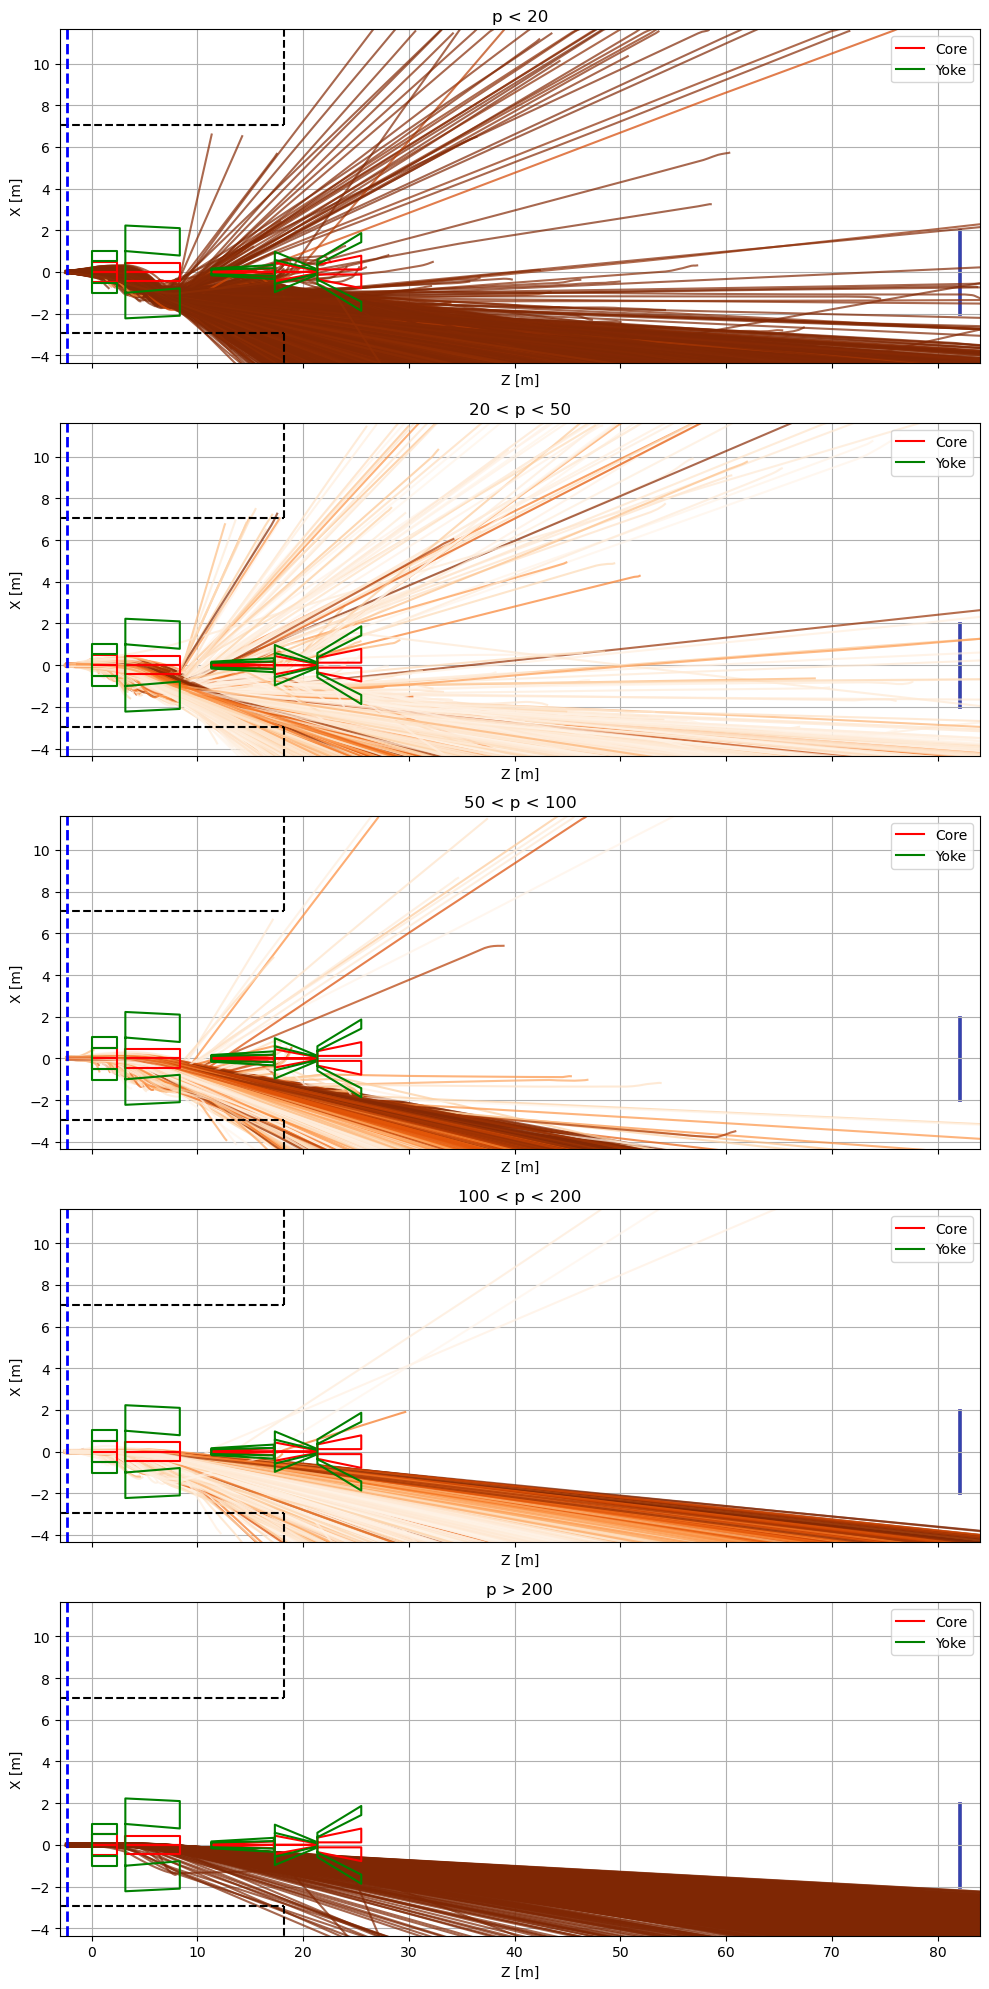

In [8]:
TCC8 = (2.05-5, 2.05+5)
ECN3 = (3.64-8, 3.64+8) 
shift = -2.345
cavern_transition = 20.518+shift

fig, axes = plt.subplots(len(momentum_ranges),1, figsize=(10, 20), sharex=True)
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_ylabel('X [m]')
    ax.set_xlabel('Z [m]')


cmap = plt.cm.Oranges
n_p = np.zeros(len(momentum_ranges))
for d in data:
    p = (d['px'][0]**2 + d['py'][0]**2 + d['pz'][0]**2)**0.5
    for idx, (pmin, pmax) in enumerate(momentum_ranges):
        norm = mpl.colors.Normalize(vmin=pmin, vmax=pmax)
        color = cmap(norm(p))
        if (p > pmin) and (pmax is None or p < pmax):
            n_p[idx] += 1
            if n_p[idx] >= 50_000: break
            axes[idx].plot(d['z'], d['x'], color=color,alpha=0.7)
            break

z_gap = 0.1
z = 0.0
for m, idx in params_lib.new_parametrization.items():
    p = params[idx]
    if not ((p[0]<1) or (p[1]<1)):  # Skip if any dimension is less than 1m
        core_poly, yoke_poly = get_arb8_xz(p, z_start=z, z_gap=0 if m == 'HA' else z_gap)
        core_poly = np.vstack([core_poly, core_poly[::-1] * np.array([-1, 1])])
        yoke_poly = np.vstack([yoke_poly, yoke_poly[::-1] * np.array([-1, 1])])
        for ax in axes:
            ax.plot(core_poly[:,1], core_poly[:,0], 'r-', label='Core' if m == 'HA' else None)
            ax.plot(yoke_poly[:,1], yoke_poly[:,0], 'g-', label='Yoke' if m == 'HA' else None)

    z += 2 * p[0]/100
    if m=='HA': z += z_gap 


for ax in axes:
    ax.plot([-5, cavern_transition], [TCC8[0], TCC8[0]], 'k--')
    ax.plot([cavern_transition, cavern_transition], [TCC8[0], ECN3[0]], 'k--')
    ax.plot([-5, cavern_transition], [TCC8[1], TCC8[1]], 'k--')
    ax.plot([cavern_transition, cavern_transition], [TCC8[1], ECN3[1]], 'k--')

    rect = patches.Rectangle((82, -2), 0.1, 4, linewidth=2, 
                            edgecolor='darkblue', facecolor='deepskyblue', alpha=0.7)
    ax.add_patch(rect)
    ax.axvline(-2.345, color='blue', linestyle='--', linewidth=2)


    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_ylim(ECN3[0], ECN3[1])
    ax.set_xlim(-3, 84)

plt.tight_layout()
print(f"Number of particles in each momentum range:")
for idx, (pmin, pmax) in enumerate(momentum_ranges):
    print(f"{titles[idx]}: {n_p[idx]} particles")
plt.show()

In [9]:
x = []
y = []
z = []
px = []
py = []
pz = []
pdg = []
x_sens = []
y_sens = []
px_sens = []
py_sens = []
pz_sens = []
for i in data:
    if np.abs(i['pdg_id']).astype(int) != 13: continue
    x.append(i['x'])
    y.append(i['y'])
    z.append(i['z'])
    px.append(i['px'])
    py.append(i['py'])
    pz.append(i['pz'])
    pdg.append(i['pdg_id']) 
    assert (i['z'][-1]<83) & (i['z'][-1]>81), f"Z coordinate out of sens plane: {i['z'][-1]}"
    x_sens.append(i['x'][-1])
    y_sens.append(i['y'][-1])
    px_sens.append(i['px'][-1])
    py_sens.append(i['py'][-1])
    pz_sens.append(i['pz'][-1])
p_sens = np.sqrt(np.array(px_sens)**2 + np.array(py_sens)**2 + np.array(pz_sens)**2)
mask_t1 = (np.abs(x_sens)<2)&(np.abs(y_sens)<3)
number_of_hits = sum(mask_t1)
print(f"Number of hits: {number_of_hits}")

AssertionError: Z coordinate out of sens plane: 83.00312249578022

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist2d(x_sens, y_sens, bins=100,  cmap='viridis', norm=LogNorm())
plt.colorbar(label='Number of muons')
plt.plot([-2, 2, 2, -2, -2], [-3, -3, 3, 3, -3], color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Histogram of muons in z=84m')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(x_sens, y_sens, s = 0.5, c=p_sens, cmap='viridis')
plt.colorbar(label='Momentum of hits')
plt.plot([-2, 2, 2, -2, -2], [-3, -3, 3, 3, -3], color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.show()